## Predictive modeling of future customer demand trends

In [1]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
from pandas import concat
import numpy as np
from math import sqrt

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from matplotlib import colors
%matplotlib inline

In [2]:
df = '/Users/sseyeoni/Documents/jupyter/Cintas/Results/MBAinfo_Retail_Clean_update.xlsx'
df = pd.read_excel(df)

df.head()

,Material,Year/Period,Retail_sales
0,110,2020-04-01,183175
1,111,2020-04-01,243
2,112,2020-04-01,2096
3,113,2020-04-01,1673
4,120,2020-04-01,178781


In [3]:
jdf = '/Users/sseyeoni/Documents/jupyter/Cintas/Results/MARA_Clean.xlsx'
jdf = pd.read_excel(jdf)

jdf = jdf[['Material','Material Group']]
jdf.head()

,Material,Material Group
0,1,TRAINING
1,110,MISC_FA
2,112,MISC_FA
3,113,MISC_FA
4,120,MISC_FA


In [4]:
# perform left join on the 'Material' column
left_join = pd.merge(df, jdf, on='Material', how='left')
left_join.head()

,Material,Year/Period,Retail_sales,Material Group
0,110,2020-04-01,183175,MISC_FA
1,111,2020-04-01,243,NaN
2,112,2020-04-01,2096,MISC_FA
3,113,2020-04-01,1673,MISC_FA
4,120,2020-04-01,178781,MISC_FA


In [5]:
df = left_join
df = df.rename(columns={'Year/Period':'Date', 'Retail_sales':'Retail_Value'})

In [6]:
# extract the rows of each Material Group

TREATMENT = df[df['Material Group'] == 'TREATMENT']

TABLETS = df[df['Material Group'] == 'TABLETS']

BANDAGES = df[df['Material Group'] == 'BANDAGES']

HANDPROT = df[df['Material Group'] == 'HANDPROT']

EYEPROT = df[df['Material Group'] == 'EYEPROT']

DRESSING = df[df['Material Group'] == 'DRESSING']

EYE = df[df['Material Group'] == 'EYE']

EMERG_FA = df[df['Material Group'] == 'EMERG_FA']

INSTRUMNT = df[df['Material Group'] == 'INSTRUMNT']

SKINCARE = df[df['Material Group'] == 'SKINCARE']

In [8]:
# Change Material_Group
Material_Group = EMERG_FA

In [9]:
# Each Material Group's retail value grouped by each date !!!!!!!!!!!!!
gdf = Material_Group.groupby('Date')['Retail_Value'].sum()
gdf = gdf.reset_index()
gdf.head()

,Date,Retail_Value
0,2020-04-01,8054
1,2020-05-01,7196
2,2020-06-01,14175
3,2020-07-01,12947
4,2020-08-01,15112


In [10]:
gdf.Date = pd.to_datetime(gdf.Date)

gdf = gdf.set_index("Date")
gdf.head()

,Retail_Value
Date,
2020-04-01,8054
2020-05-01,7196
2020-06-01,14175
2020-07-01,12947
2020-08-01,15112


In [11]:
gdf.tail()

,Retail_Value
Date,
2022-11-01,104020
2022-12-01,41173
2023-01-01,36986
2023-02-01,28739
2023-03-01,27821


### Rolling Statistics

<AxesSubplot: xlabel='Date'>

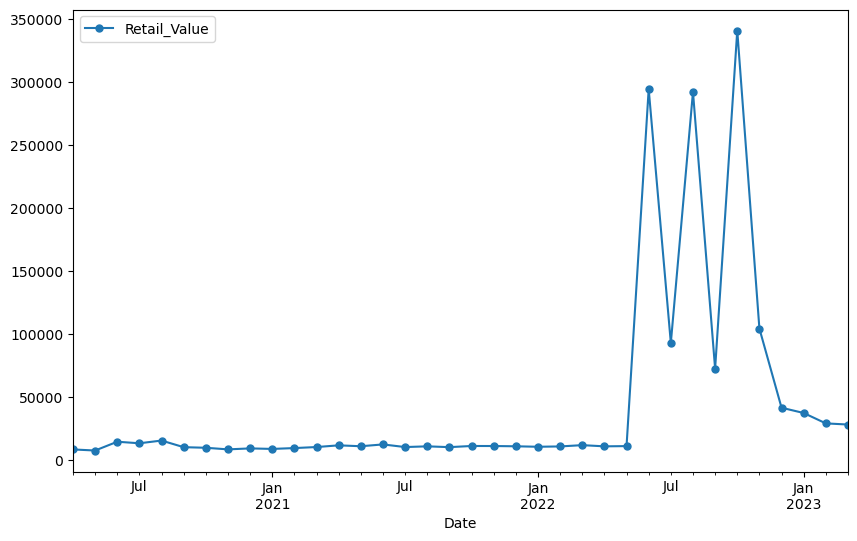

In [12]:
gdf['Retail_Value'].plot(figsize = (10,6), legend=True, marker='o', markersize=5)

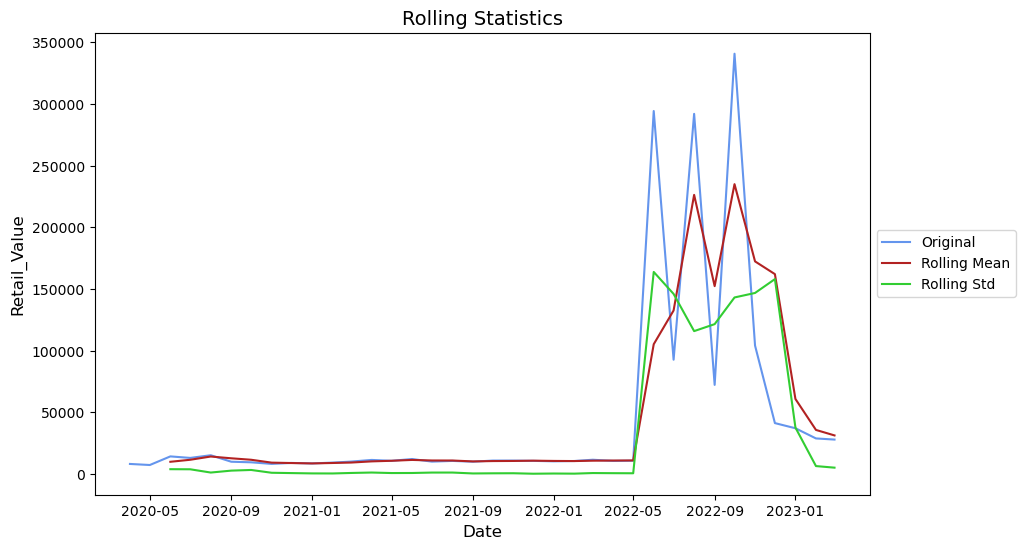

In [13]:
rolling_mean = gdf.rolling(window=3).mean()
rolling_std = gdf.rolling(window=3).std()

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(gdf, color='cornflowerblue', label='Original')
ax.plot(rolling_mean, color='firebrick', label='Rolling Mean')
ax.plot(rolling_std, color='limegreen', label='Rolling Std')

ax.set_xlabel('Date', size=12)
ax.set_ylabel('Retail_Value', size=12)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Rolling Statistics', size=14)

plt.show()

### Acf (Autocorrelation)

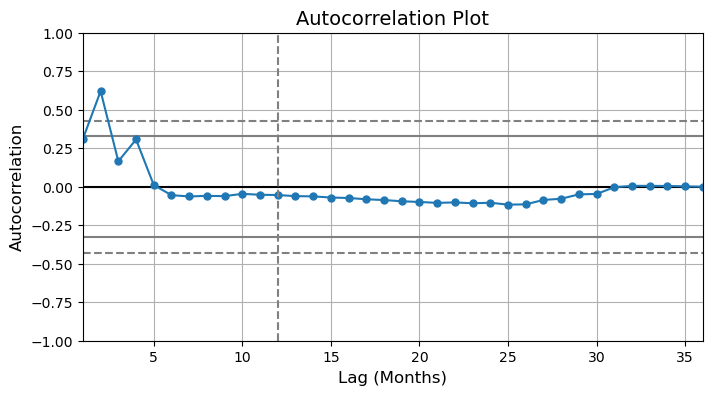

In [14]:
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)

plt.figure(figsize=(8, 4))
pd.plotting.autocorrelation_plot(gdf['Retail_Value'], marker='o', markersize=5)
plt.axvline(x=12, linestyle='--', color='grey')
plt.xlabel('Lag (Months)', fontsize=12)  # explicitly reference the xlabel function from matplotlib.pyplot
plt.ylabel('Autocorrelation', fontsize=12)
plt.title('Autocorrelation Plot', fontsize=14)
plt.show()

### Pacf (Partial Autocorrelation)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 800x400 with 0 Axes>

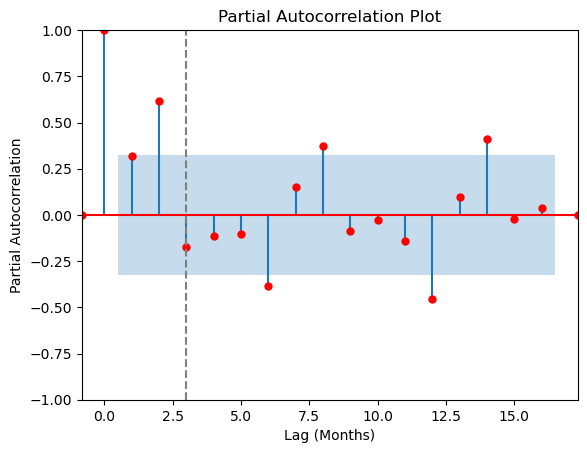

In [15]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)
# assume gdf is a pandas DataFrame containing the time series data

plt.figure(figsize=(8, 4))
plot_pacf(gdf['Retail_Value'], lags=16, marker='o', markersize=5, color='red')
plt.axvline(x=3, linestyle='--', color='grey')
plt.xlabel('Lag (Months)')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Plot')
plt.show()

### Decomposition

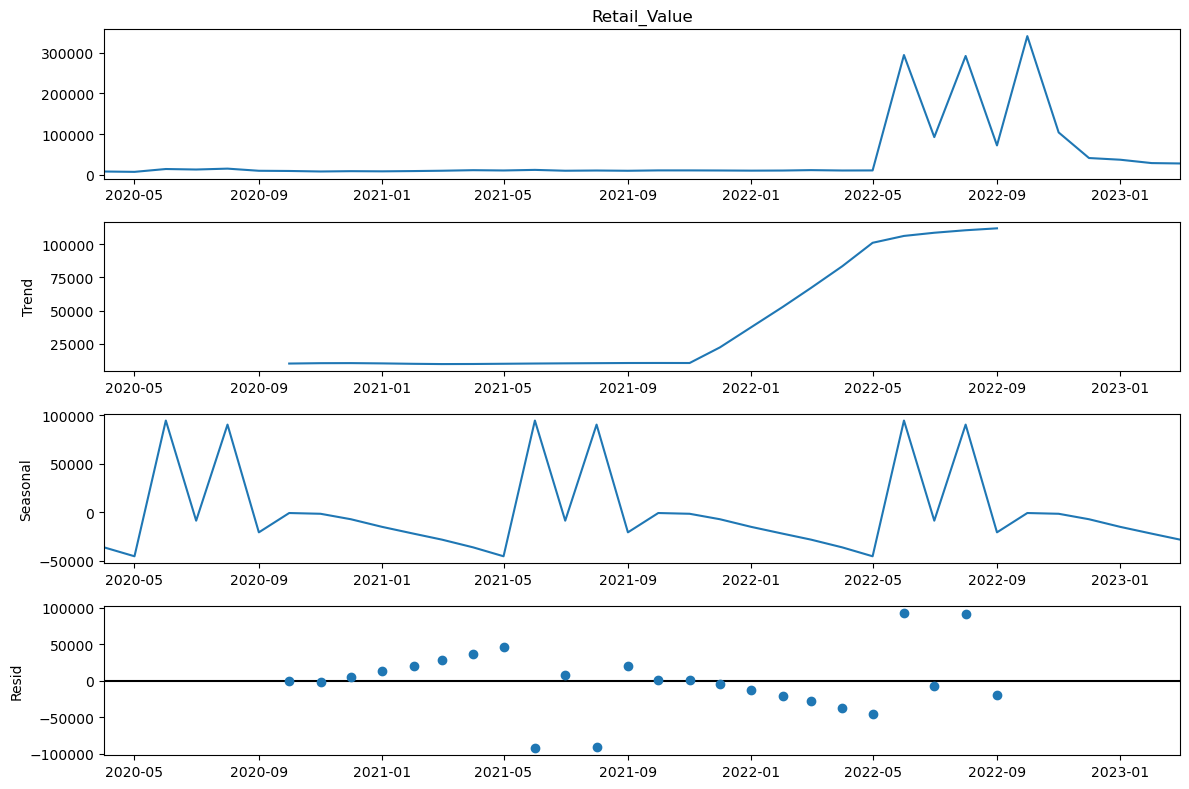

In [16]:
rcParams['figure.figsize'] = 12, 8
dec = seasonal_decompose(gdf["Retail_Value"], model = "add")
dec.plot();

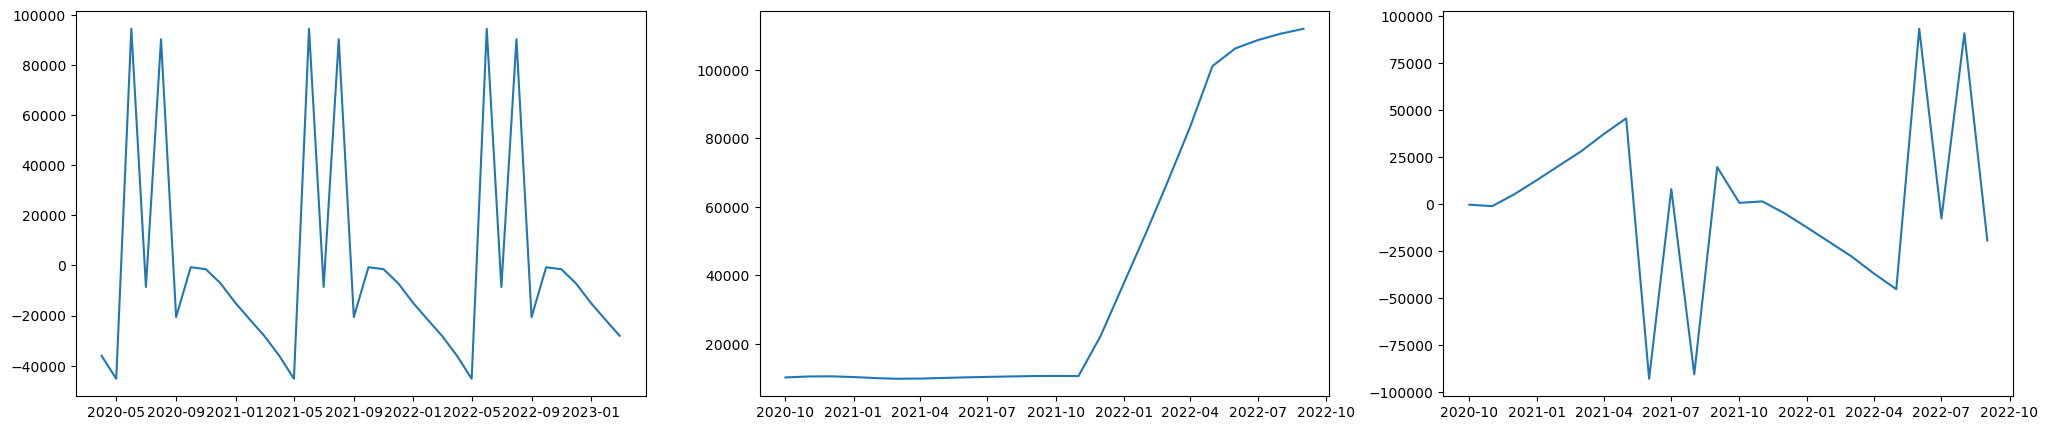

In [17]:
plt.figure(figsize = (25, 5))
a = seasonal_decompose(gdf["Retail_Value"], model = "add")
plt.subplot(1, 3, 1)
plt.plot(dec.seasonal)

plt.subplot(1, 3, 2)
plt.plot(dec.trend)

plt.subplot(1, 3, 3)
plt.plot(dec.resid)

plt.show()

In [18]:
# check for stationarity using the Augmented Dickey-Fuller test
result = adfuller(gdf['Retail_Value'])
print('ADF Statistic: {:.3f}'.format(result[0]))
print('p-value: {:.3f}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {:.3f}'.format(key, value))

ADF Statistic: -0.654
p-value: 0.858
Critical Values:
	1%: -3.689
	5%: -2.972
	10%: -2.625


## Forecasting Model

**ARIMA Model** stands for Auto-Regressive Integrated Moving Average.<br> It is is used for predicting future trends on a time series data. It is model that form of regression analysis.

**Auto-Regressive** models predict future behavior using past behavior where there is some correlation between past and future data.

**Integration** is the difference between present and previous observations. It is used to make the time series stationary.

**Moving Average** is a statistical method that takes the updated average of values to help cut down on noise. It takes the average over a specific interval of time

**p**: Value just before convergence in pacf. ( =3 )<br>
**d** : Check whether there is a trend by adf test and visual confirmation of the trend ( =0 )<br>
**q** : value just before convergence in acf ( =1)<br>
**P** : Check how many times the seasonality cycle was repeated in the pacf ( =0 )<br>
**D**: Check whether there is seasonality, 1 or 0 ( =0 ) depending on the need for seasonality difference <br>
**Q**: Check how many times the seasonal cycle based on acf has been repeated (=1)<br>
**m** : seasonal period ( =12 )

In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

train_data = gdf[:len(gdf)-12]
test_data = gdf[len(gdf)-12:]

arima_model = SARIMAX(gdf['Retail_Value'], order = (2,0,4), seasonal_order = (0,0,0,12))
arima_result = arima_model.fit()
arima_result.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27481D+01    |proj g|=  8.62257D-01

At iterate    5    f=  1.24039D+01    |proj g|=  2.12464D-01

At iterate   10    f=  1.23848D+01    |proj g|=  8.52908D-03

At iterate   15    f=  1.23846D+01    |proj g|=  5.90540D-03

At iterate   20    f=  1.23845D+01    |proj g|=  1.01736D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     20     21      1     0     0   1.017D-05   1.238D+01
  F =   12.384545849628173     

CONVERG

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Retail_Value   No. Observations:                   36
Model:               SARIMAX(2, 0, 4)   Log Likelihood                -445.844
Date:                Thu, 27 Apr 2023   AIC                            905.687
Time:                        17:42:32   BIC                            916.772
Sample:                    04-01-2020   HQIC                           909.556
                         - 03-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2670      1.351      0.198      0.843      -2.380       2.914
ar.L2          0.0626      0.553      0.113      0.910      -1.022       1.147
ma.L1          0.0056      1.483      0.004      0.997      -2.901       2.912
ma.L2          0.7441      0.356      2.089      0.037       0.046       1.442
ma.L3         -0.0339      1.270     -0.027      0.979      -2.524       2.456
ma.L4          0.7722      0.243      3.183      0.001       0.297       1.248
sigma2      4.493e+09   9.78e-10   4.59e+18      0.000    4.49e+09    4.49e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               893.50
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):             552.63   Skew:                             4.47
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.92e+34. Standard errors may be unstable.
"""

In [28]:
arima_pred = arima_result.predict(start = len(train_data), end = len(gdf)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

2022-04-01      8086.909935
2022-05-01      8243.832818
2022-06-01      7164.105694
2022-07-01     84842.693625
2022-08-01    256931.919861
2022-09-01     82557.585141
2022-10-01    282167.849502
2022-11-01     92767.699079
2022-12-01    119556.198584
2023-01-01     15747.539152
2023-02-01     -1094.911361
2023-03-01     37037.294341
Freq: MS, Name: ARIMA Predictions, dtype: float64

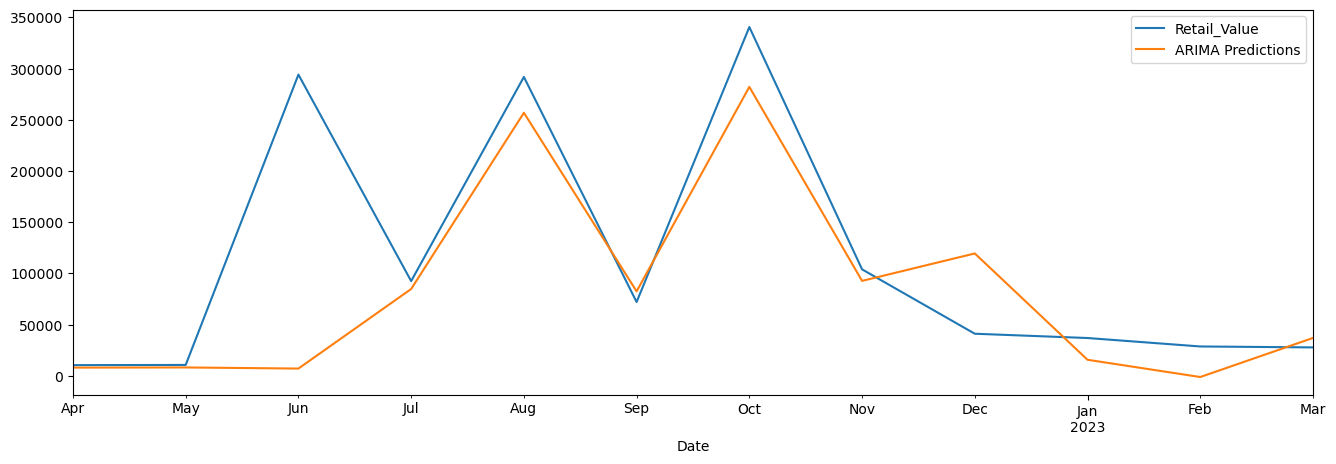

In [29]:
test_data['Retail_Value'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

In [30]:
from statsmodels.tools.eval_measures import rmse

arima_rmse_error = rmse(test_data['Retail_Value'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = gdf['Retail_Value'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 7907638410.446967
RMSE Error: 88924.90320740848
Mean: 44475.63888888889


In [31]:
arima_pred_f = arima_result.predict(start = len(gdf), end = len(gdf)+12, typ="levels").rename("ARIMA Predictions")
arima_pred_f

2023-04-01   -29500.283625
2023-05-01     2350.376509
2023-06-01    22020.329482
2023-07-01    -1059.654934
2023-08-01     1095.383166
2023-09-01      226.157561
2023-10-01      128.951523
2023-11-01       48.588120
2023-12-01       21.045333
2024-01-01        8.660741
2024-02-01        3.629858
2024-03-01        1.511336
2024-04-01        0.630756
Freq: MS, Name: ARIMA Predictions, dtype: float64

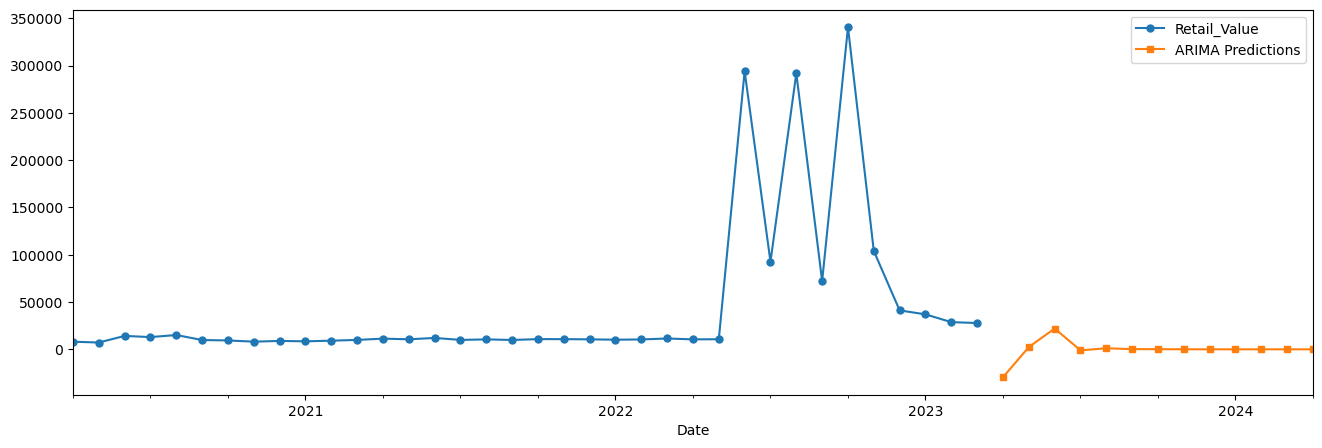

In [32]:
gdf['Retail_Value'].plot(figsize = (16,5), legend=True, marker='o', markersize=5)
arima_pred_f.plot(legend = True, marker='s', markersize=5);

In [33]:
pdf = arima_pred_f.to_frame(name='Retail_Value')
pdf.head()

,Retail_Value
2023-04-01,-29500.283625
2023-05-01,2350.376509
2023-06-01,22020.329482
2023-07-01,-1059.654934
2023-08-01,1095.383166


In [34]:
udf = pd.concat([gdf, pdf])

udf.reset_index(inplace=True)
udf = udf.rename(columns = {'index':'Date'})

In [35]:
udf.head()

,Date,Retail_Value
0,2020-04-01,8054.0
1,2020-05-01,7196.0
2,2020-06-01,14175.0
3,2020-07-01,12947.0
4,2020-08-01,15112.0


In [36]:
udf.to_csv('/Users/sseyeoni/Documents/jupyter/Cintas/Forecasting/Results/Retail_Predictive_Model_EMERG_FA.csv', index=False)